In [81]:
%load_ext autoreload
%autoreload 2
import json
from scipy import sparse
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progress_bar
from collections import defaultdict
import string
import scipy.stats as stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading query lists

In [43]:
with open('queryTypeGlobal.json') as json_data:
    qTypeGlobal = json.load(json_data)

In [44]:
def loadJSON(sampleFilename):
    with open(sampleFilename) as json_data:
        sample_10000 = json.load(json_data)
    return sample_10000

In [45]:
# Sample 10000 A
sample_10000_A = loadJSON("sample-v2-10000-A.txt")

In [46]:
# Sample 10000 B
sample_10000_B = loadJSON("sample-v2-10000-B.txt")

In [47]:
# Sample 10000 C
sample_10000_C = loadJSON("sample-v2-10000-C.txt")

In [48]:
# Sample 10000 D
sample_10000_D = loadJSON("sample-v2-10000-D.txt")

In [49]:
len(set(sample_10000_C) & set(sample_10000_D))

print(sample_10000_A[:10])

[32805, 343102, 666213, 929213, 281028, 418473, 587272, 648286, 175840, 807055]


# How we do it

#### Scoring functions to evaluate:
    - BM25 
    - BM25P10-top5-idf 
    - BM25P10-top5-tfidf 
    - BM25P10-top10-idf 
    - BM25P10-top10-tfidf

For each scoring function result file we evaluate the 4 query types (A,B,C and D). We have some intermediate files from which we read the position of the corrent doc match. We evaluate if in top 1,10,100.

What are the metrics we are interested in?
- Win/loss ratio
- Average rank
- Precision @ 1,10,100
- MRR

There might be some queries in the input files with no results

## Metrics

In [10]:
def averageRank(rank_list):
    return np.mean(rank_list)

In [11]:
def winLossRatio(rank_list, interval = [0,1]):
    correct_class = [r for r in rank_list if r >= interval[0] and r < interval[1]]
#     print(len(correct_class),len(rank_list))
    if len(correct_class) == len(rank_list): return "-"
    else: return len(correct_class)/(len(rank_list) - len(correct_class))

In [12]:
def precision(rank, at=10):
    n_rel_retrieved = 0
    if rank <= at:
        n_rel_retrieved = 1
    return n_rel_retrieved/at

In [13]:
def avgPrecision(rank_list, at=1):
    prec_list = [precision(r, at) for r in rank_list]
    return np.mean(prec_list)

In [14]:
def MRR(rank_list, at=None):
    if at is not None:
        inverse_ranks = [1./x for x in rank_list if x <= at]
    else:
        inverse_ranks = [1./x for x in rank_list]
#     print(len(rank_list))
    return np.mean(inverse_ranks)

In [15]:
def RR(rank_list, at=None):
    if at is not None:
        inverse_ranks = [1./x for x in rank_list if x <= at]
    else:
        inverse_ranks = [1./x for x in rank_list]
#     print(len(rank_list))
    return inverse_ranks

In [16]:
### http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-24.html

In [17]:
def two_sample_ttest_ind(a,b):
    return stats.ttest_ind(a, b, equal_var=False)

In [18]:
def paired_ttest_in_time(a, b):
    return stats.ttest_reltest_rel(a, b)

In [19]:
intervals = [[0,1], [1,10], [10,100], [100,1000]]

def getMetrics(ranks, positions, interval):
    print("Avg. rank:", averageRank(ranks))
    print("Win/loss", winLossRatio(positions, interval))
    print("Avg. P@1", avgPrecision(ranks, at=1))
    print("Avg. P@10", avgPrecision(ranks, at=10))
    print("Avg. P@100", avgPrecision(ranks, at=100))
    print("Avg. P@1000", avgPrecision(ranks, at=1000))
    print("MRR", MRR(ranks))

# EVAL 

In [20]:
queryTypes = ["A", "B", "C", "D"]

In [21]:
def getQueryTypeSets(positions):
    A = [x for x in positions if x==0]
    B = [x for x in positions if x>0 and x<10]
    C = [x for x in positions if x>=10 and x<100]
    D = [x for x in positions if x>=100 and x<1000]
    print("A",len(A))
    print("B", len(B))
    print("C",len(C))
    print("D", len(D))

In [22]:
def getQueryTypeSetsInline(positions):
    A = [x for x in positions if x==0]
    B = [x for x in positions if x>0 and x<10]
    C = [x for x in positions if x>=10 and x<100]
    D = [x for x in positions if x>=100 and x<1000]
#     return " , ".join([str(len(A)),str(len(B)),str(len(C)), str(len(D)), str(10000-len(A) -len(B)-len(C)-len(D))])
    return len(A), len(B), len(C), len(D)


### BM25

In [155]:
def evalBM25(filename, qt):
    Bm25queryRankDict = loadJSON(filename)

    positions = list(Bm25queryRankDict.values())
    ranks = [x+1 for x in positions]
#     getMetrics(ranks, positions, interval=intervals[queryTypes.index(qt)])

    getMetrics(ranks, positions, interval=intervals[queryTypes.index(qt)])
    getQueryTypeSets(positions)

    #get some data
    bm25_mrr = MRR(ranks)
    bm25_avg_ranks = np.mean(ranks)
    bm25_query_class = getQueryTypeSetsInline(positions)

    return bm25_mrr, bm25_avg_ranks, bm25_query_class

In [156]:
bm25_mrr_dict = dict()
bm25_avg_rank_dict = dict()
for qt in queryTypes:
    print(qt)
    filename = "evalOutput/BM25-signal-sample-10000-"+qt+".txt"
    bm25_mrr, bm25_avg_ranks, bm25_query_class = evalBM25(filename, qt)
    bm25_mrr_dict[("bm25-plain", qt)] = bm25_mrr
    bm25_avg_rank_dict[("bm25-plain", qt)] = bm25_avg_ranks
    print()

A
Avg. rank: 1.0
Win/loss -
Avg. P@1 1.0
Avg. P@10 0.1
Avg. P@100 0.01
Avg. P@1000 0.001
MRR 1.0
A 10000
B 0
C 0
D 0

B
Avg. rank: 3.9538
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.1
Avg. P@100 0.01
Avg. P@1000 0.001
MRR 0.32496452381
A 0
B 10000
C 0
D 0

C
Avg. rank: 34.88
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.0
Avg. P@100 0.01
Avg. P@1000 0.001
MRR 0.0416907718055
A 0
B 0
C 10000
D 0

D
Avg. rank: 364.3362
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.0
Avg. P@100 0.0
Avg. P@1000 0.001
MRR 0.00404004666534
A 0
B 0
C 0
D 10000



In [157]:
bm25_mrr_dict 

{('bm25-plain', 'A'): 1.0,
 ('bm25-plain', 'B'): 0.32496452380952384,
 ('bm25-plain', 'C'): 0.041690771805544057,
 ('bm25-plain', 'D'): 0.0040400466653436112}

In [158]:
print(np.mean(list(bm25_avg_rank_dict.values())))
bm25_avg_rank_dict

101.0425


{('bm25-plain', 'A'): 1.0,
 ('bm25-plain', 'B'): 3.9538000000000002,
 ('bm25-plain', 'C'): 34.880000000000003,
 ('bm25-plain', 'D'): 364.33620000000002}

### BM25P 

In [179]:
# Settings
dirEval = "./TerrierOutput-grid-search-alpha-p/eval/"
baseTypes = ["top5-idf", 
             "top5-tfidf",
             "top10-idf",
             "top10-tfidf"]
queryTypes = ["A", "B","C", "D"]
ending = ".txt" # sometimes res


prettyNames={"top5-idf":"BM25P Top-5-IDF", "top5-tfidf":"BM25P Top-5-TFIDF", 
            "top10-idf":"BM25P Top-10-IDF", "top10-tfidf":"BM25P Top-10-TFIDF"}

### MRR plots for different alpha

In [162]:
import os

mrr_dict = defaultdict(list)
rr_dict = defaultdict(list)
average_rank_dict = defaultdict(list)
rank_dict = defaultdict(list)
for filename in os.listdir(dirEval):
    name_items = filename.split("-")
    baseType = name_items[2]+"-"+name_items[3]
    alpha = filename.split(".")[0].split("-")[10]
    
    queryRankDict = loadJSON(dirEval+filename)
    positions = list(queryRankDict.values())
    ranks = [x+1 for x in positions]
    mrr_dict[(baseType, name_items[6])].append(((int(alpha)), MRR(ranks)))
    rr_dict[(baseType, name_items[6])].append(((int(alpha)), RR(ranks)))
    average_rank_dict[(baseType, name_items[6])].append(((int(alpha)), np.mean(ranks)))
    rank_dict[(baseType, name_items[6])].append(((int(alpha)), ranks))

In [163]:
print(mrr_dict.keys())
# print(mrr_dict['top5-idf', 'B'])

dict_keys([('top5-idf', 'B'), ('top5-tfidf', 'A'), ('top10-tfidf', 'A'), ('top10-tfidf', 'C'), ('bm25-plain', 'C'), ('top5-tfidf', 'D'), ('top10-idf', 'D'), ('top5-tfidf', 'C'), ('top5-idf', 'C'), ('bm25-plain', 'A'), ('top10-idf', 'A'), ('top5-idf', 'A'), ('top10-tfidf', 'B'), ('top10-tfidf', 'D'), ('top5-tfidf', 'B'), ('top10-idf', 'B'), ('top10-idf', 'C'), ('top5-idf', 'D'), ('bm25-plain', 'B'), ('bm25-plain', 'D')])


In [186]:
# JUST FOR PRINTING 

for alpha in [10, 15, 20, 25]:
    for baseType in baseTypes:
#         print(alpha, baseType, end=" ")
        vals = []
        for queryType in queryTypes:
            key = (baseType, queryType)
            mrr = [y for x,y in mrr_dict[baseType, queryType] if x==alpha]
#             print(queryType, mrr, end=" ")
            vals.append(mrr[0])
#         print()
#         print(vals)
#         print()
        print(" & ".join([str("{:.3f}".format(i)) for i in vals]))
#         print()
    print()

0.952 & 0.373 & 0.070 & 0.009
0.982 & 0.366 & 0.055 & 0.005
0.976 & 0.365 & 0.055 & 0.005
0.988 & 0.359 & 0.051 & 0.005

0.958 & 0.377 & 0.072 & 0.010
0.980 & 0.370 & 0.060 & 0.006
0.977 & 0.368 & 0.059 & 0.006
0.984 & 0.364 & 0.055 & 0.005

0.959 & 0.379 & 0.074 & 0.012
0.976 & 0.369 & 0.063 & 0.008
0.974 & 0.370 & 0.062 & 0.008
0.980 & 0.366 & 0.059 & 0.007

0.958 & 0.378 & 0.075 & 0.013
0.973 & 0.369 & 0.065 & 0.009
0.970 & 0.368 & 0.065 & 0.009
0.975 & 0.362 & 0.061 & 0.008



In [180]:
def plot_and_sort(baseType, mrr_dict, queryTypes):
    for queryType in queryTypes:
        key = (baseType, queryType)
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
#         print(y)
        plt.plot(x,y , label=prettyNames[key[0]] + " " + key[1])
        #print(max(y),x[y.index(max(y))])
#         plt.plot(x[y.index(max(y))], max(y), "or")
        baseline_y = [bm25_mrr_dict[("bm25-plain", queryType)]] * len(x)
#         print(baseline_y)
        plt.plot(x, baseline_y, label="BM25 " + str(queryType), linestyle="--")
#         print()
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend(loc='upper right')
#     plt.title("BM25P varying alpha")
    plt.xlabel("Alpha")
    plt.ylabel("MRR@1000")
    plt.savefig("Signal-BM25-vary-alpha-"+baseType+".pdf", bbox_inches='tight')
    plt.show()

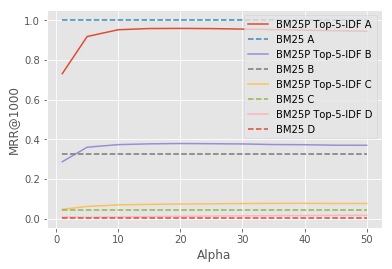

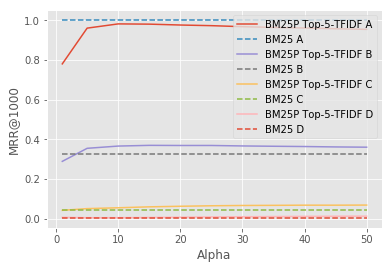

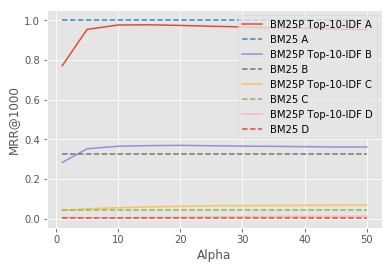

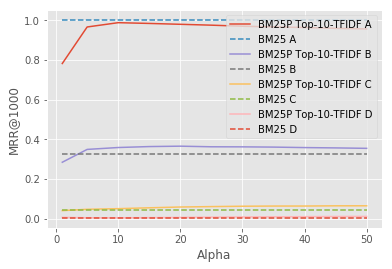

In [181]:
plt.style.use("ggplot")
for baseType in baseTypes:
    plot_and_sort(baseType, mrr_dict, queryTypes)

### Statistical significance for MRR values

In [166]:
print(rr_dict.keys())

dict_keys([('top5-idf', 'B'), ('top5-tfidf', 'A'), ('top10-tfidf', 'A'), ('top10-tfidf', 'C'), ('bm25-plain', 'C'), ('top5-tfidf', 'D'), ('top10-idf', 'D'), ('top5-tfidf', 'C'), ('top5-idf', 'C'), ('bm25-plain', 'A'), ('top10-idf', 'A'), ('top5-idf', 'A'), ('top10-tfidf', 'B'), ('top10-tfidf', 'D'), ('top5-tfidf', 'B'), ('top10-idf', 'B'), ('top10-idf', 'C'), ('top5-idf', 'D'), ('bm25-plain', 'B'), ('bm25-plain', 'D')])


In [167]:
def check_statistical_significance(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
        
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        max_index = x[y.index(max(y))]
        
        for first, second in zip(sorted_rr_list, sorted_rr_list[1:]):
            print(first[0], second[0])
            print(y[x.index(first[0])], y[x.index(second[0])])
            print(two_sample_ttest_ind(first[1], second[1]))

In [168]:
def check_statistical_significance_with_max(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
        
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        max_alpha = x[y.index(max(y))]
        print(max_alpha)
        max_rrs = sorted_rr_list[x.index(max_alpha)][1]
        
        for first in sorted_rr_list:
            print(first[0], max_alpha)
            print(y[x.index(first[0])], y[x.index(max_alpha)])
            print(two_sample_ttest_ind(first[1], max_rrs))

In [174]:
def check_statistical_significance_with_baseline(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print("\x1b[0m " + str(key))
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
#         print(sorted_rr_list[:1]) # list of (alpha, rr_list)
#         print([x for x,y in sorted_rr_list])
        
        
        base_rr_list = rr_dict[("bm25-plain", queryType)]
        sorted_base_rr_list = sorted(base_rr_list, key=lambda tup: tup[0])
#         print(sorted_base_rr_list) # list of (alpha, rr_list) 
#         print([x for x,y in sorted_base_rr_list])
        
        for first in sorted_rr_list:
            print("\x1b[0m " + str(first[0]) + " " + str(sorted_base_rr_list[0][0]), end= " ")
            print(np.mean(first[1]), np.mean(sorted_base_rr_list[0][1]))
            result = two_sample_ttest_ind(first[1], sorted_base_rr_list[0][1])
            print(result)
            print("\x1b[31m Statistically diff" if result[1]<0.05 else "\033[34m NOT statistically different")
        
        print()

In [175]:
# check_statistical_significance_with_max('top5-idf', rr_dict, mrr_dict, queryTypes)

In [176]:
for baseType in baseTypes:
    check_statistical_significance_with_baseline(baseType, rr_dict, mrr_dict, queryTypes)

 ('top5-idf', 'A')
 1 0 0.730923639428 1.0
Ttest_indResult(statistic=-70.705378549265703, pvalue=0.0)
 Statistically diff
 5 0 0.917882274567 1.0
Ttest_indResult(statistic=-37.230787655950628, pvalue=3.0176752492063659e-284)
 Statistically diff
 10 0 0.95221213023 1.0
Ttest_indResult(statistic=-28.793406753219212, pvalue=3.2079481818520839e-175)
 Statistically diff
 15 0 0.958245889011 1.0
Ttest_indResult(statistic=-27.182806439779693, pvalue=4.82030117347e-157)
 Statistically diff
 20 0 0.958864261523 1.0
Ttest_indResult(statistic=-26.948518691137483, pvalue=1.7885651563691887e-154)
 Statistically diff
 25 0 0.95790752766 1.0
Ttest_indResult(statistic=-27.038039621667163, pvalue=1.8749526359441653e-155)
 Statistically diff
 30 0 0.955453672596 1.0
Ttest_indResult(statistic=-27.624663522723413, pvalue=6.099393919541549e-162)
 Statistically diff
 35 0 0.952865271577 1.0
Ttest_indResult(statistic=-28.268714939012678, pvalue=3.3536547364394933e-169)
 Statistically diff
 40 0 0.94993465556

Ttest_indResult(statistic=20.647248440427948, pvalue=6.1601536806965352e-93)
 Statistically diff
 30 0 0.0660946091886 0.0416907718055
Ttest_indResult(statistic=20.557527620146541, pvalue=3.7533378239526314e-92)
 Statistically diff
 35 0 0.0668268128519 0.0416907718055
Ttest_indResult(statistic=20.454498987562395, pvalue=2.944844726092294e-91)
 Statistically diff
 40 0 0.0674178930959 0.0416907718055
Ttest_indResult(statistic=20.3758302173344, pvalue=1.4090481478478545e-90)
 Statistically diff
 45 0 0.0682044745368 0.0416907718055
Ttest_indResult(statistic=20.306667710003623, pvalue=5.5810277425097095e-90)
 Statistically diff
 50 0 0.0684247181342 0.0416907718055
Ttest_indResult(statistic=20.148051396080866, pvalue=1.248267718304355e-88)
 Statistically diff

 ('top10-idf', 'D')
 1 0 0.00719420124124 0.00404004666534
Ttest_indResult(statistic=11.928155317866182, pvalue=1.6970612289342955e-32)
 Statistically diff
 5 0 0.00512778797101 0.00404004666534
Ttest_indResult(statistic=19.0227097

Ttest_indResult(statistic=11.572868278977934, pvalue=9.6951104626149929e-31)
 Statistically diff
 45 0 0.0110295923363 0.00404004666534
Ttest_indResult(statistic=11.695996597594004, pvalue=2.3641072829859029e-31)
 Statistically diff
 50 0 0.0115306472763 0.00404004666534
Ttest_indResult(statistic=11.95539341102109, pvalue=1.142687214981935e-32)
 Statistically diff



### WIN/LOSS ratio for varying alpha

In [53]:
import os

class_dict = defaultdict(list)
for filename in os.listdir(dirEval):
    name_items = filename.split("-")
    baseType = name_items[2]+"-"+name_items[3]
    alpha = filename.split(".")[0].split("-")[10]
    
    queryRankDict = loadJSON(dirEval+filename)
    positions = list(queryRankDict.values())
    ranks = [x+1 for x in positions]
    new_class = getQueryTypeSetsInline(positions)
    class_dict[(baseType, name_items[6])].append(((int(alpha)), new_class))

In [54]:
def getWinLossRatio(baseType, queryType, alpha, class_dict):
    line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
    if queryType == "A":
        losses = sum(line[1][1:])
        wins = []
        for queryType in ["B","C","D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][0])
        return sum(wins)/losses
    if queryType == "B":
        losses = sum(line[1][2:])
        wins = []
        for queryType in ["C","D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][1])
        return sum(wins)/losses
    if queryType == "C":
        losses = sum(line[1][3:])
        wins = []
        for queryType in ["D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][2])
        return sum(wins)/losses
        

In [55]:
getWinLossRatio("top5-tfidf", "C", 10, class_dict)

3.682730923694779

In [56]:
win_loss_dict = defaultdict(list) ### the list contains WL for multiple alpha

for baseType in baseTypes:
    for queryType in queryTypes:
        if queryType is not "D":
            for alpha,_ in class_dict[(baseType, queryType)]:
                wl = getWinLossRatio(baseType, queryType, alpha, class_dict)
                win_loss_dict[(baseType, queryType)].append(((int(alpha)), wl))

In [57]:
print(win_loss_dict)

defaultdict(<class 'list'>, {('top5-idf', 'A'): [(15, 1.639777468706537), (5, 0.847758887171561), (30, 1.7476510067114095), (50, 1.4871220604703248), (40, 1.6136919315403424), (20, 1.747175141242938), (35, 1.6765083440308088), (45, 1.5134502923976607), (25, 1.7745098039215685), (10, 1.432129514321295), (1, 0.25191055759977354)], ('top5-idf', 'B'): [(10, 2.2531645569620253), (20, 2.6043276661514683), (30, 2.2433510638297873), (1, 0.35560344827586204), (45, 1.8280739934711643), (50, 1.7437759336099585), (35, 2.0754017305315204), (5, 1.361266294227188), (15, 2.561622464898596), (40, 1.962920046349942), (25, 2.4644412191582004)], ('top5-idf', 'C'): [(20, 1.4252747252747253), (1, 0.38395316804407714), (35, 0.9633867276887872), (40, 0.9038461538461539), (30, 1.060884070058382), (45, 0.8442513368983957), (5, 1.0517241379310345), (50, 0.8003814367450731), (25, 1.2282398452611218), (15, 1.6354799513973268), (10, 1.58675799086758)], ('top5-tfidf', 'A'): [(30, 1.819672131147541), (45, 1.514285714

In [182]:
def plot_and_sort_WL(baseType, win_loss_dict, queryTypes):
    for queryType in ["A","B","C"]:
        key = (baseType, queryType)
        wl_list = win_loss_dict[key]
#         print(key)
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(wl_list, key=lambda tup: tup[0])]
#         print(x)
        y = [y for x,y in sorted(wl_list, key=lambda tup: tup[0])]
#         print(y)
        plt.plot(x, y , label=prettyNames[key[0]]+" "+key[1])
        #print(max(y),x[y.index(max(y))])
#         plt.plot(x[y.index(max(y))], max(y), "or")
    plt.plot(x, [1 for x in range(len(x))], ":k", label="win-loss threshold")
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend(loc='upper right')
#     plt.title("BM25P varying alpha")
    plt.xlabel("Alpha")
    plt.ylabel("WinLossRatio")
    plt.savefig("Signal-BM25-win-loss-"+baseType+".pdf", bbox_inches='tight')

    plt.show()

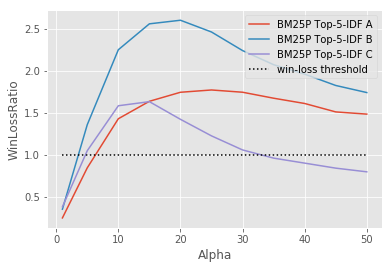

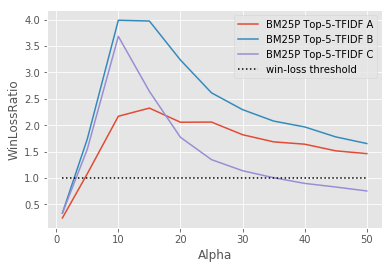

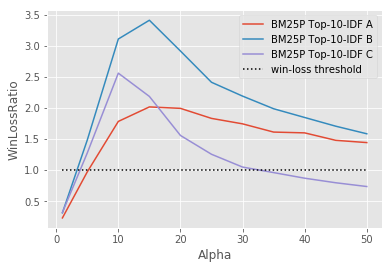

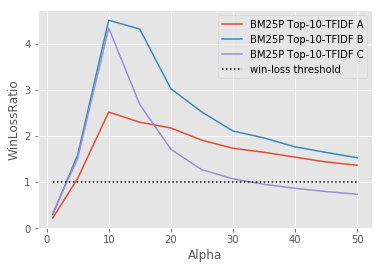

In [183]:
for baseType in baseTypes:
    plot_and_sort_WL(baseType, win_loss_dict, queryTypes)

## Todo:

- intersect qid from wins of C for alpha 10 with wins of C for alpha 40

# Average rank

In [78]:
for baseType in baseTypes:

    for queryType in queryTypes:
        key = (baseType, queryType)
        avg_rank_list = average_rank_dict[key]
        x = [x for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]

        avg_rank_bm25 = bm25_avg_rank_dict[("bm25-plain", queryType)]
        #for i in range(len(y)):
        for i in [2,3,4,5,6]:
            
            print("\x1b[0m "+str(key), x[i], y[i], avg_rank_bm25, end='')
            print("\x1b[31m WIN" if y[i]<avg_rank_bm25 else "\x1b[0m ") 
        print()
        
    print("--------------------------------")

 ('top5-idf', 'A') 10 1.1844 1.0 
 ('top5-idf', 'A') 15 1.1482 1.0 
 ('top5-idf', 'A') 20 1.1479 1.0 
 ('top5-idf', 'A') 25 1.1603 1.0 
 ('top5-idf', 'A') 30 1.1805 1.0 

 ('top5-idf', 'B') 10 4.756 3.9538 
 ('top5-idf', 'B') 15 4.5066 3.9538 
 ('top5-idf', 'B') 20 4.539 3.9538 
 ('top5-idf', 'B') 25 4.6673 3.9538 
 ('top5-idf', 'B') 30 4.8334 3.9538 

 ('top5-idf', 'C') 10 41.897489749 34.88 
 ('top5-idf', 'C') 15 40.2349 34.88 
 ('top5-idf', 'C') 20 41.797 34.88 
 ('top5-idf', 'C') 25 44.2254225423 34.88 
 ('top5-idf', 'C') 30 47.1514151415 34.88 

 ('top5-idf', 'D') 10 336.022608888 364.3362 WIN
 ('top5-idf', 'D') 15 342.638312049 364.3362 WIN
 ('top5-idf', 'D') 20 345.11172679 364.3362 WIN
 ('top5-idf', 'D') 25 347.874466367 364.3362 WIN
 ('top5-idf', 'D') 30 350.53006236 364.3362 WIN

--------------------------------
 ('top5-tfidf', 'A') 10 1.05 1.0 
 ('top5-tfidf', 'A') 15 1.0529 1.0 
 ('top5-tfidf', 'A') 20 1.0698 1.0 
 ('top5-tfidf', 'A') 25 1.0933 1.0 
 ('top5-tfidf', 'A') 30 

BM25 avg rank : 101.0425
top5-idf avg rank[1-50] :  [ 128.427   98.083   95.965   97.132   98.149   99.482  100.924  101.98
  103.343  104.463  105.35 ]
top5-tfidf avg rank[1-50] :  [ 126.321   94.135   93.427   95.058   96.888   99.089  100.561  101.85
  103.173  104.726  106.009]
top10-idf avg rank[1-50] :  [ 128.467   96.086   94.809   96.116   97.666   99.904  101.068  102.568
  103.974  105.396  106.421]
top10-tfidf avg rank[1-50] :  [ 126.598   95.075   94.456   95.994   97.313   99.767  101.179  102.453
  103.734  105.346  106.804]


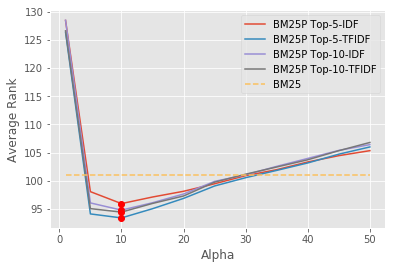

In [184]:
print("BM25 avg rank :", np.mean(list(bm25_avg_rank_dict.values())))

def plot_avg_rank():
    for baseType in baseTypes:
        all_avg_rank = np.zeros(11)
        for queryType in queryTypes:
            key = (baseType, queryType)
            avg_rank_list = average_rank_dict[key]
            x = [x for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
            y = [y for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
            all_avg_rank += np.array(y)
        print(baseType+ " avg rank[1-50] : ", all_avg_rank/4)
        y_avg = all_avg_rank/4
        
        plt.plot(x,y_avg, label=prettyNames[baseType])
        #print(max(y),x[y.index(max(y))])
        plt.plot(x[list(y_avg).index(min(y_avg))], min(y_avg), "or")
        # print bm25 as baseline
    baseline_y = [np.mean(list(bm25_avg_rank_dict.values()))] * len(x)
    plt.plot(x, baseline_y, label="BM25", linestyle="--")
    plt.legend(loc='upper right')
    plt.xlabel("Alpha")
    plt.ylabel("Average Rank")
    plt.savefig("Signal-BM25-avg-rank.pdf", bbox_inches='tight')
    plt.show()
    
plot_avg_rank()  

BM25 avg mrr : 0.34267383557
top5-idf avg mrr[1-50] :  [ 0.268  0.337  0.351  0.355  0.356  0.356  0.356  0.355  0.354  0.353
  0.352]
top5-tfidf avg mrr[1-50] :  [ 0.28   0.343  0.352  0.354  0.354  0.354  0.353  0.352  0.351  0.35
  0.349]
top10-idf avg mrr[1-50] :  [ 0.276  0.34   0.35   0.353  0.353  0.353  0.352  0.351  0.351  0.349
  0.349]
top10-tfidf avg mrr[1-50] :  [ 0.279  0.342  0.35   0.352  0.353  0.352  0.351  0.35   0.349  0.348
  0.347]


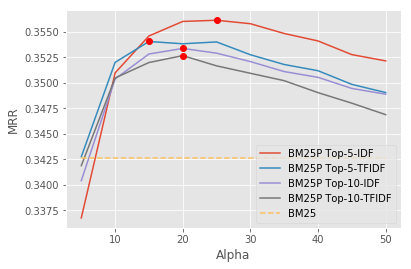

In [187]:
print("BM25 avg mrr :", np.mean(list(bm25_mrr_dict.values())))

def plot_avg_mrr():
    for baseType in baseTypes:
        all_avg_mrr = np.zeros(11)
        for queryType in queryTypes:
            key = (baseType, queryType)
            mrr_list = mrr_dict[key]
            x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
            y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
            all_avg_mrr += np.array(y)
        print(baseType+ " avg mrr[1-50] : ", all_avg_mrr/4)
        y_avg = all_avg_mrr/4
        
        plt.plot(x[1:],y_avg[1:], label=prettyNames[baseType])
        #print(max(y),x[y.index(max(y))])
        plt.plot(x[list(y_avg).index(max(y_avg))], max(y_avg), "or")
        # print bm25 as baseline
    baseline_y = [np.mean(list(bm25_mrr_dict.values()))] * len(x)
    plt.plot(x[1:], baseline_y[1:], label="BM25", linestyle="--")
    plt.legend(loc='lower right')
    plt.xlabel("Alpha")
    plt.ylabel("MRR")
    plt.savefig("Signal-BM25-avg-mrr.pdf", bbox_inches='tight')
    plt.show()
    
plot_avg_mrr() 

In [188]:
def check_statistical_significance_avg_with_baseline(baseType, rr_dict, mrr_dict, queryTypes, alpha):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    accumulator_method = []
    accumulator_base = []
    
    print("\x1b[0m " + str(baseType) + " " + str(alpha))
    for queryType in queryTypes:
        key = (baseType, queryType)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
#         print(sorted_rr_list) # list of (alpha, rr_list)
#         print([x for x,y in sorted_rr_list])
        accumulator_method.extend([y for x,y in sorted_rr_list if x == alpha][0])
#         print("M: ", len(accumulator_method))
        
        
        
        base_rr_list = rr_dict[("bm25-plain", queryType)]
        sorted_base_rr_list = sorted(base_rr_list, key=lambda tup: tup[0])
#         print(sorted_base_rr_list) # list of (alpha, rr_list) 
#         print([x for x,y in sorted_base_rr_list])
        accumulator_base.extend([y for x,y in sorted_base_rr_list if x == 0][0])
#         print("B: ", len(accumulator_base))

        

    result = two_sample_ttest_ind(accumulator_method, accumulator_base)
    print(np.mean(accumulator_method), np.mean(accumulator_base))
    print(result)
    print("\x1b[31m Statistically diff" if result[1]<0.05 else "\033[34m NOT statistically different")

In [189]:
for baseType in baseTypes:
    for alpha in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
        check_statistical_significance_avg_with_baseline(baseType, rr_dict, mrr_dict, queryTypes, alpha)

 top5-idf 1
0.296613005139 0.34267383557
Ttest_indResult(statistic=-16.081961324203693, pvalue=4.2621810662873585e-58)
 Statistically diff
 top5-idf 5
0.349616864947 0.34267383557
Ttest_indResult(statistic=2.3956717522246174, pvalue=0.016592270481642815)
 Statistically diff
 top5-idf 10
0.359541844719 0.34267383557
Ttest_indResult(statistic=5.8113609593611564, pvalue=6.2204349637310246e-09)
 Statistically diff
 top5-idf 15
0.363352990115 0.34267383557
Ttest_indResult(statistic=7.1158245474198836, pvalue=1.121885505756486e-12)
 Statistically diff
 top5-idf 20
0.366242165836 0.34267383557
Ttest_indResult(statistic=8.0915451550719695, pvalue=5.9744601377282471e-16)
 Statistically diff
 top5-idf 25
0.367937214031 0.34267383557
Ttest_indResult(statistic=8.6568991082790507, pvalue=4.9375241022125102e-18)
 Statistically diff
 top5-idf 30
0.36908988432 0.34267383557
Ttest_indResult(statistic=9.0365124108856971, pvalue=1.6531591010173173e-19)
 Statistically diff
 top5-idf 35
0.369578676576 0.34